In [1]:
import os
import pickle as pkl

from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data

In [2]:
import math
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns
import scipy

import bokeh.io
import bokeh.plotting
import bokeh.models

import warnings
warnings.filterwarnings('ignore')

bokeh.io.output_notebook()

Loading BokehJS ...

# Load in the datasets

In [3]:
# Load in the hygiene gene data
hyg_df = pd.read_csv("../data/hygiene_genes.csv", header=0)
hyg_df.drop(columns=['Unnamed: 0', 'Chromosome', 'Hygienic FPKM', 'Non-hygienic FPKM', 'q_value', 'Gene product'], inplace=True)

In [4]:
# Load in the NCBI bee gene reference data
ref_genes = pd.read_csv(
    "../data/amel_genes.tsv", 
    sep="\t", 
    header=0, 
)

# remove rows that do not have genomic coordinates
nan_idx = ref_genes[ref_genes['Annotation Genomic Range Start'].isnull()].index
ref_genes.drop(labels=nan_idx, inplace=True)

# drop spurious duplicate
ref_genes.drop(labels=115, inplace=True)

# find the gene length
ref_genes['Gene length'] = np.abs(ref_genes['Annotation Genomic Range Stop'].values - ref_genes['Annotation Genomic Range Start'].values)

# drop unnecessary columns
ref_genes.drop(columns=[
    'Description', 
    'Gene Type', 
    'Gene Group Identifier', 
    'Gene Group Method', 
    # 'Annotation Genomic Range Accession', 
    'Annotation Genomic Range Stop',
    'Annotation Genomic Range Start',
], 
            inplace=True,
           )



In [5]:
# Load in the original file into Pandas DF
counts_df = pd.read_csv(
    "../data/GSE81664_Raw_counts_RNA-Seq_Beedoc.txt", 
    sep="\t", 
    header=0, 
    names=["Gene", "A1", "A2", "A3", "B1", "B2", "B3", "C1", "C2", "C3", "D1", "D2"]
)

# transpose the DF s.t. each bee is a row
counts_df = counts_df.transpose()

# make the "Gene" row the new columns
counts_df.columns = counts_df.iloc[0]
counts_df.drop(inplace=True, index=["Gene"])

In [6]:
# set up a datafame that maintains the conditions
clinical_df = pd.DataFrame()
index = ["A1", "A2", "A3", "B1", "B2", "B3", "C1", "C2", "C3", "D1", "D2"]
condtn = ["control", "control", "control", "Nosema", "Nosema", "Nosema", "BQCV", "BQCV", "BQCV", "both", "both"]
clinical_df["condition"] = condtn
clinical_df.index = index

# Data wrangling

There are some genes in the dataset that do not have a proper NCBI ID match. We remove those genes.

In [7]:
# Create a renaming dictionary
rename_dct = {}

# keep track of genes that have no NCBI record
drop_genes = []

for column in list(counts_df.columns):
    val = ref_genes.loc[ref_genes['NCBI GeneID'] == column, 'Symbol'].values
    if any(val):
        rename_dct[column] = val[0]
    else:
        drop_genes.append(column)
        
# drop the unmatched genes
drop_genes = drop_genes[1:]
counts_df.drop(columns=drop_genes, inplace=True)

# rename the leftover genes with symbols
counts_df.rename(mapper=rename_dct, axis=1, inplace=True)

It is common practice to remove genes that have total counts < 10:

In [8]:
genes_to_keep = counts_df.columns[counts_df.sum(axis=0) >= 10]
counts_df = counts_df[genes_to_keep]

## Plotting gene counts for each sample
It is important to see if our data fits a Poisson dstribution of transcript counts. We are simply plotting the sample gene counts in descending ranked order.

In [9]:
# create a figure object
counts_fig = bokeh.plotting.figure(
    height=400,
    width=600,
    title="Gene counts in each sample",
    x_axis_label="Counts",
    y_axis_label="Number of genes",
    x_range=[0, 20000]
)


colors = [
    '#393b79',
    '#5254a3',
    '#6b6ecf',
    '#637939',
    '#8ca252',
    '#b5cf6b',
    '#8c6d31',
    '#bd9e39',
    '#e7ba52',
    '#843c39',
    '#ad494a',
]
labels = [
    'control 1',
    'control 2',
    'control 3',
    'Nosema 1',
    'Nosema 2',
    'Nosema 3',
    'BQCV 1',
    'BQCV 2',
    'BQCV 3',
    'both 1',
    'both 2',
]

for i in range(len(counts_df)):
    # extract thhe data and condition
    data = counts_df.iloc[i]
    condition = clinical_df.iloc[i]['condition']
    vals = data.transpose().iloc[1:].values
    
    # set up a histogram
    hist, edges = np.histogram(vals, bins=500)
    
    # add the histogram to the figure
    counts_fig.line(
        x=edges[:-1], 
        y=hist, 
        color=colors[i], 
        legend_label=labels[i], 
        line_width=2,
    )

bokeh.io.show(counts_fig)

In [10]:
# save the figure
counts_fig.output_backend = "svg"
bokeh.io.export_svgs(counts_fig, filename="../figures/gene_count_cdf.svg")

['../figures/gene_count_cdf.svg']

In [11]:
# save the figure as PNG for slides
bokeh.io.export_png(counts_fig, filename="../figures/gene_count_cdf.png")

'/Users/anastasiyagrebin/Desktop/OneDrive_California_Institute_of_Technology/grad_classes/20.440/zomBEES/figures/gene_count_cdf.png'

It looks like all samples roughly have Poisson-distributed gene counts, which is what we might expect. We now check this by looking at the mean and variance of each sample. A Poisson distribution should have thhe same mean and variance.

In [12]:
# set up a figure
# create a figure object
poisson_fig = bokeh.plotting.figure(
    height=500,
    width=500,
    title="Mean vs variance for each gene",
    y_axis_label="Mean counts",
    x_axis_label="Variance of counts",
    x_range=[0, 200000],
)

# add a threshhold line
poisson_fig.line(x=[0,700000], y=[0, 700000], color='black')

colors = ['#5254a3', '#8ca252', '#bd9e39', '#ad494a',]
i = 0
for condition in ['control', 'Nosema', 'BQCV', 'both']:
    # extract the data and condition
    idx = list(np.where(clinical_df['condition'] == condition)[0])
    sub_df = counts_df.iloc[idx].transpose()
    sub_df['Mean'] = np.mean(sub_df, axis=1)
    sub_df['Variance'] = np.std(sub_df, axis=1)
    
    # add the dots to the figure
    poisson_fig.scatter(
        y=sub_df['Mean'].values, 
        x=sub_df['Variance'].values, 
        color=colors[i], 
        legend_label=condition, 
    )
    
    i = i + 1
    
poisson_fig.legend.location="top_left"

bokeh.io.show(poisson_fig)

In [13]:
# save the figure
poisson_fig.output_backend = "svg"
bokeh.io.export_svgs(poisson_fig, filename="../figures/mean_vs_var.svg")

['../figures/mean_vs_var.svg']

In [14]:
bokeh.io.export_png(poisson_fig, filename="../figures/mean_vs_var.png")

'/Users/anastasiyagrebin/Desktop/OneDrive_California_Institute_of_Technology/grad_classes/20.440/zomBEES/figures/mean_vs_var.png'

It looks like pretty much all gene count means are greater than the variance, which suggests that our gene counts are in fact not poisson distributed. However, since we have very few replicates, it may be wiser to assume a negative binomial distribution.

# Principal Component Analysis
We perform PCA on the dataset to see how much dimensionality reduction can be helpful and wheter we can see very clear clustering of the data without much additional analysis. Since PCA is sensitive to scale, we are normalizing all features, i.e. gene counts, by removing te mean and scaling to unit variance. The goal is to find the most clustering.

In [15]:
# 4 clusters correspond to 4 experimental conditions
pca = PCA()

# scale all features (i.e. gene counts)
X = counts_df
X_scaled = pd.DataFrame()
for gene in X.columns.values:
    # subtract the mean and divide by SD
    gene_mean = np.mean(X[gene])
    gene_sd = np.std(X[gene])
    if gene_sd == 0.0:
        new_gene = X[gene]
    else:
        new_gene = (X[gene] - gene_mean) / gene_sd
    
    X_scaled[gene] = new_gene
    

# perform PCA on masked dataset
Xt = pca.fit_transform(X_scaled.values)

In [16]:
# pick a colorblind-friendly scheme
color_dct = {"control":colors[0], "Nosema":colors[1], "BQCV":colors[2], "both":colors[3]}
colors = [color_dct[i] for i in condtn]


# how much variance is explained by first two components
pc1_var, pc2_var = pca.explained_variance_ratio_[0:2]

# create a Bokeh figure object
pca_fig = bokeh.plotting.figure(
    title="PCA of scaled data",
    x_axis_label=f"PC1 ({round(pc1_var,2)} explained variance)",
    y_axis_label=f"PC2 ({round(pc2_var,2)} explained variance)",
    height=500,
    width=500,
)

# add the points based on PC transforms
for i in range(len(Xt[0])):
    pca_fig.scatter(
        Xt[i,0], 
        Xt[i,1], 
        color=color_dct[condtn[i]],
        size=10,
        legend_label=condtn[i]
    )


pca_fig.xaxis.major_tick_line_color = None
pca_fig.yaxis.major_tick_line_color = None
pca_fig.xaxis.major_label_text_color = None
pca_fig.yaxis.major_label_text_color = None

# export the figure
# bokeh.io.export_png(pca_fig, filename="../figures/pca_fig.png")


bokeh.io.show(pca_fig)

In [17]:
# save the figure
pca_fig.output_backend = "svg"
bokeh.io.export_svgs(pca_fig, filename="../figures/pca.svg")

['../figures/pca.svg']

In [18]:
bokeh.io.export_png(pca_fig, filename="../figures/pca_fig.png")

'/Users/anastasiyagrebin/Desktop/OneDrive_California_Institute_of_Technology/grad_classes/20.440/zomBEES/figures/pca_fig.png'

It looks like most of the variance in the data is explained by the first principal component.

# Hierarchical clustering

In [19]:
# define function that calculates the TPM of a gene column
def get_tpm(gene_name, counts_df, ref_genes):
    # get the gene length
    if not (gene_name in ref_genes['Symbol'].values):
        return [0]
    length = ref_genes.loc[ref_genes['Symbol'] == gene_name, 'Gene length'].values[0]
    
    # get the gene data
    counts = counts_df[gene_name].values
    
    A = counts * 1e3 / length
    if np.sum(A) == 0:
        return [0]
    else:
        return A * 1e6 * 1 / np.sum(A)

In [20]:
# calculate the TPM for all genes
tpm_counts = pd.DataFrame()
tpm_counts['condition'] = clinical_df['condition']

for gene in counts_df.columns[1:]:
    tpm = get_tpm(gene, counts_df, ref_genes)
    
    # remove columns that have zeros for every sample
    if len(tpm) > 1:
        tpm_counts[gene] = tpm
    

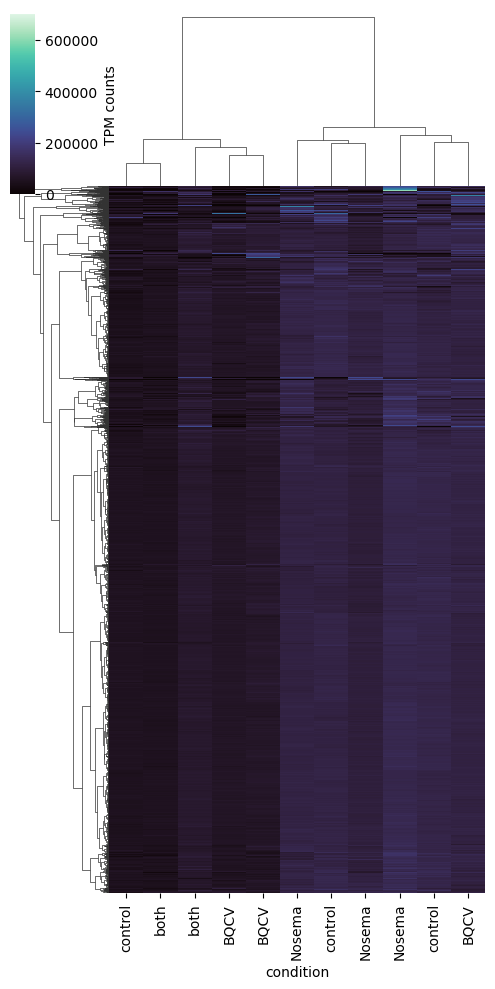

In [21]:
tpm_counts = tpm_counts.transpose()
tpm_counts.columns = tpm_counts.iloc[0]
tpm_counts.drop(index=['condition'], inplace=True, axis=0)

# use Seaborn to plot a clustermap
result = sns.clustermap(
    tpm_counts.astype(float), 
    method='ward',
    cmap='mako',
    figsize=(5,10),
    cbar_kws={"label":"TPM counts"},
    yticklabels=False,
    xticklabels=True,
)

In [22]:
# save the plot
result.savefig('../figures/cluster_heatmap.svg', format="svg", dpi=1200)
result.savefig('../figures/cluster_heatmap.png', format="png")

# Differential gene expression of hygiene-associated genes
Since we are primarilly interested in the differential expression of a fairly small group of hygiene-associated and non-hygiene-associated genes characterized by prior studies, we will only perform DGE analysis on this subset of genes to reduce the multiple hypothesis correction needed. We are staying blinded to the rest of the dataset, for now.

### Slice out the hygiene-related genes for DEA

In [23]:
# make a list of genes of interest
H_gene_names = hyg_df.loc[hyg_df['Hygiene'] == 'H', 'Gene'].values
NH_gene_names = hyg_df.loc[hyg_df['Hygiene'] == 'NH', 'Gene'].values
goi_names = np.concatenate([H_gene_names, NH_gene_names])

# find all genes of interest that are in the dataset
goi_present = []
for goi in goi_names:
    if goi in counts_df.columns:
        goi_present.append(goi)
        
# slice out the relevant genes
counts_df_small = counts_df[goi_present]

### Create the appropriate DESeq2 objects

In [26]:
# initialize a DESeq2 object that stores dispersion and LFC froom the passed data
dds = DeseqDataSet(
    counts=counts_df_small,
    clinical=clinical_df,
    design_factors="condition",
    refit_cooks=True,
    n_cpus=8,
)

# fit the dispersions and LFCs
dds.deseq2()

# save results of deseq2 for future retrieval
with open(os.path.join('../data/', "dds.pkl"), "wb") as f:
    pkl.dump(dds, f)

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.05 seconds.

Fitting dispersion trend curve...
... done in 0.03 seconds.

Fitting MAP dispersions...
... done in 0.05 seconds.

Fitting LFCs...
... done in 0.04 seconds.

Refitting 2 outliers.

Fitting dispersions...
... done in 0.00 seconds.

Fitting MAP dispersions...
... done in 0.00 seconds.

Fitting LFCs...
... done in 0.00 seconds.



### Calculate p-values
This is based off a Wald test for significance and automatically calculates FDR-adjusted p-values.

In [28]:
# create a statisticcs object for each comparison against the control 
stat_res_BQCV = DeseqStats(
    dds, 
    contrast=['condition', 'BQCV', 'control'],
    n_cpus=8,
)
stat_res_BQCV.summary()
dea_result_BQCV_small = stat_res_BQCV.results_df
dea_result_BQCV_small['color'] = ["orange" if np.abs(x)>=1 else "gray" for x in dea_result_BQCV_small['log2FoldChange']]
dea_result_BQCV_small['line_color'] = ["red" if x in NH_gene_names else "green" for x in dea_result_BQCV_small.index]

stat_res_Nosema = DeseqStats(
    dds, 
    contrast=['condition', 'Nosema', 'control'],
    n_cpus=8,
)
stat_res_Nosema.summary()
dea_result_Nosema_small = stat_res_Nosema.results_df
dea_result_Nosema_small['color'] = ["orange" if np.abs(x)>=1 else "gray" for x in dea_result_Nosema_small['log2FoldChange']]
dea_result_Nosema_small['line_color'] = ["red" if x in NH_gene_names else "green" for x in dea_result_Nosema_small.index]


stat_res_both = DeseqStats(
    dds, 
    contrast=['condition', 'both', 'control'],
    n_cpus=8,
)
stat_res_both.summary()
dea_result_both_small = stat_res_both.results_df
dea_result_both_small['color'] = ["orange" if np.abs(x)>=1 else "gray" for x in dea_result_both_small['log2FoldChange']]
dea_result_both_small['line_color'] = ["red" if x in NH_gene_names else "green" for x in dea_result_both_small.index]

Running Wald tests...
... done in 0.05 seconds.

Log2 fold change & Wald test p-value: condition BQCV vs control


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Gene,,,,,,
Cac,6941.210269,0.519467,0.287674,1.805748,0.070958,0.501947
CPR5,174.481881,-0.008297,0.206442,-0.040189,0.967943,0.988226
Gat-a,8975.083100,0.223739,0.223667,1.000322,0.317155,0.811794
LOC100576840,399.537171,-0.007985,0.228168,-0.034995,0.972084,0.988226
LOC100578672,129.024992,-0.276709,0.358151,-0.772605,0.439756,0.898807
LOC100578804,272.983602,-0.324675,0.657710,-0.493645,0.621557,0.903164
LOC408734,52.108082,0.455737,0.302835,1.504902,0.132349,0.580301
LOC410149,149.818041,-0.732400,0.471277,-1.554075,0.120167,0.570791
LOC410207,2162.138246,-0.065355,0.842936,-0.077533,0.938200,0.988226


Running Wald tests...
... done in 0.05 seconds.

Log2 fold change & Wald test p-value: condition Nosema vs control


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Gene,,,,,,
Cac,6941.210269,0.352578,0.287634,1.225787,0.220279,0.810146
CPR5,174.481881,0.011070,0.203029,0.054523,0.956519,0.971468
Gat-a,8975.083100,0.035267,0.223628,0.157705,0.874689,0.941640
LOC100576840,399.537171,-0.127434,0.227100,-0.561135,0.574705,0.810146
LOC100578672,129.024992,-0.346097,0.355737,-0.972899,0.330603,0.810146
LOC100578804,272.983602,-1.111298,0.658048,-1.688781,0.091261,0.743129
LOC408734,52.108082,0.382816,0.297161,1.288248,0.197660,0.810146
LOC410149,149.818041,-0.830667,0.469650,-1.768692,0.076945,0.730980
LOC410207,2162.138246,-0.033467,0.842863,-0.039706,0.968327,0.971468


Running Wald tests...
... done in 0.04 seconds.

Log2 fold change & Wald test p-value: condition both vs control


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Gene,,,,,,
Cac,6941.210269,0.565040,0.321697,1.756434,0.079014,0.321701
CPR5,174.481881,0.003424,0.236180,0.014497,0.988433,0.988433
Gat-a,8975.083100,0.276880,0.250147,1.106870,0.268350,0.728378
LOC100576840,399.537171,0.137604,0.256616,0.536226,0.591802,0.919528
LOC100578672,129.024992,-0.231476,0.404861,-0.571743,0.567496,0.919528
LOC100578804,272.983602,-1.369295,0.740096,-1.850159,0.064291,0.299777
LOC408734,52.108082,0.191200,0.354914,0.538721,0.590080,0.919528
LOC410149,149.818041,-0.980766,0.532858,-1.840576,0.065684,0.299777
LOC410207,2162.138246,0.202637,0.942484,0.215003,0.829765,0.963370


### Volcano plots
We are creating a seaorate volcano plot for each experimental condition.

In [29]:
# set up a plot figure
volcano_BQCV_small = bokeh.plotting.figure(
    title="Hygiene-associated genes under BQCV infection",
    height=500,
    width=500,
    x_axis_label="log2 (fold-change)",
    y_axis_label="-log10 (p-value)",
    y_range=[min(-np.log10(dea_result_BQCV_small['pvalue'])) - 0.5, max(-np.log10(dea_result_BQCV_small['pvalue'])) + 0.5],
    x_range=[min(dea_result_BQCV_small['log2FoldChange']) - 0.5, max(dea_result_BQCV_small['log2FoldChange']) + 0.5],
)

volcano_BQCV_small.scatter(
    x=dea_result_BQCV_small['log2FoldChange'],
    y=-np.log10(dea_result_BQCV_small['pvalue']),
    color=color_dct['BQCV'],
    line_color="white",
    size=7,
)

# label statistically significant genes
sig_df = dea_result_BQCV_small.loc[dea_result_BQCV_small['padj']<=0.05]
source = bokeh.models.ColumnDataSource(data=dict(log2FoldChange=list(sig_df['log2FoldChange'].values),
                                    y=list(-np.log10(sig_df['pvalue'].values)),
                                    names=list(sig_df.index.values)))
labels = bokeh.models.LabelSet(
    x='log2FoldChange', 
    y='y', 
    text='names',
    x_offset=5, 
    y_offset=5,
    source=source,
    render_mode='canvas'
)
volcano_BQCV_small.add_layout(labels)

volcano_BQCV_small.quad(
    left=min(dea_result_BQCV_small['log2FoldChange']) - 0.5,
    right=-1.0,
    bottom=min(-np.log10(dea_result_BQCV_small['pvalue'])) - 0.5,
    top=max(-np.log10(dea_result_BQCV_small['pvalue'])) + 0.5,
    line_color=None,
    color='green',
    alpha=0.1,
)

volcano_BQCV_small.quad(
    left=1.0,
    right=max(dea_result_BQCV_small['log2FoldChange']) + 0.5,
    bottom=min(-np.log10(dea_result_BQCV_small['pvalue'])) - 0.5,
    top=max(-np.log10(dea_result_BQCV_small['pvalue'])) + 0.5,
    line_color=None,
    color='green',
    alpha=0.1,
)


GlyphRenderer(id='4574', ...)

In [30]:
# set up a plot figure
volcano_Nosema_small = bokeh.plotting.figure(
    title="Hygiene-associated genes under Nosema infection",
    height=500,
    width=500,
    x_axis_label="log2 (fold-change)",
    y_axis_label="-log10 (p-value)",
    y_range=[min(-np.log10(dea_result_Nosema_small['pvalue'])) - 0.5, max(-np.log10(dea_result_Nosema_small['pvalue'])) + 0.5],
    x_range=[min(dea_result_Nosema_small['log2FoldChange']) - 0.5, max(dea_result_Nosema_small['log2FoldChange']) + 0.5],
)

volcano_Nosema_small.scatter(
    x=dea_result_Nosema_small['log2FoldChange'],
    y=-np.log10(dea_result_Nosema_small['pvalue']),
    color=color_dct['Nosema'],
    size=7,
    line_color='white',
)

# label statistically significant genes
sig_df = dea_result_Nosema_small.loc[dea_result_Nosema_small['padj']<=0.05]
source = bokeh.models.ColumnDataSource(data=dict(log2FoldChange=list(sig_df['log2FoldChange'].values),
                                    y=list(-np.log10(sig_df['pvalue'].values)),
                                    names=list(sig_df.index.values)))
labels = bokeh.models.LabelSet(
    x='log2FoldChange', 
    y='y', 
    text='names',
    x_offset=5, 
    y_offset=5,
    source=source,
    render_mode='canvas'
)
volcano_Nosema_small.add_layout(labels)

volcano_Nosema_small.quad(
    left=min(dea_result_Nosema_small['log2FoldChange']) - 0.5,
    right=-1.0,
    bottom=min(-np.log10(dea_result_Nosema_small['pvalue'])) - 0.5,
    top=max(-np.log10(dea_result_Nosema_small['pvalue'])) + 0.5,
    line_color=None,
    color='green',
    alpha=0.1,
)

volcano_Nosema_small.quad(
    left=1.0,
    right=max(dea_result_Nosema_small['log2FoldChange']) + 0.5,
    bottom=min(-np.log10(dea_result_Nosema_small['pvalue'])) - 0.5,
    top=max(-np.log10(dea_result_Nosema_small['pvalue'])) + 0.5,
    line_color=None,
    color='green',
    alpha=0.1,
)


GlyphRenderer(id='4630', ...)

In [31]:
# set up a plot figure
volcano_both_small = bokeh.plotting.figure(
    title="Hygiene-associated genes under dual infection",
    height=500,
    width=500,
    x_axis_label="log2 (fold-change)",
    y_axis_label="-log10 (p-value)",
    y_range=[min(-np.log10(dea_result_both_small['pvalue'])) - 0.5, max(-np.log10(dea_result_both_small['pvalue'])) + 0.5],
    x_range=[min(dea_result_both_small['log2FoldChange']) - 0.5, max(dea_result_both_small['log2FoldChange']) + 0.5],
)

volcano_both_small.scatter(
    x=dea_result_both_small['log2FoldChange'],
    y=-np.log10(dea_result_both_small['pvalue']),
    color=color_dct['both'],
    size=7,
    line_color='white',
)

# label statistically significant genes
sig_df = dea_result_both_small.loc[dea_result_both_small['padj']<=0.05]
source = bokeh.models.ColumnDataSource(data=dict(log2FoldChange=list(sig_df['log2FoldChange'].values),
                                    y=list(-np.log10(sig_df['pvalue'].values)),
                                    names=list(sig_df.index.values)))
labels = bokeh.models.LabelSet(
    x='log2FoldChange', 
    y='y', 
    text='names',
    x_offset=5, 
    y_offset=5,
    source=source,
    render_mode='canvas'
)
volcano_both_small.add_layout(labels)

volcano_both_small.quad(
    left=min(dea_result_both_small['log2FoldChange']) - 0.5,
    right=-1.0,
    bottom=min(-np.log10(dea_result_both_small['pvalue'])) - 0.5,
    top=max(-np.log10(dea_result_both_small['pvalue'])) + 0.5,
    line_color=None,
    color='green',
    alpha=0.1,
)

volcano_both_small.quad(
    left=1.0,
    right=max(dea_result_both_small['log2FoldChange']) + 0.5,
    bottom=min(-np.log10(dea_result_both_small['pvalue'])) - 0.5,
    top=max(-np.log10(dea_result_both_small['pvalue'])) + 0.5,
    line_color=None,
    color='green',
    alpha=0.1,
)

GlyphRenderer(id='4686', ...)

In [32]:
bokeh.io.show(bokeh.layouts.grid([volcano_BQCV_small, volcano_Nosema_small, volcano_both_small], ncols=2))

In [33]:
# save the volcano plots
volcano_BQCV_small.output_backend = "svg"
bokeh.io.export_svgs(volcano_BQCV_small, filename="../figures/volcano_hyg_bqcv.svg")
bokeh.io.export_png(volcano_BQCV_small, filename="../figures/volcano_hyg_bqcv.png")

volcano_Nosema_small.output_backend = "svg"
bokeh.io.export_svgs(volcano_Nosema_small, filename="../figures/volcano_hyg_nosema.svg")
bokeh.io.export_png(volcano_Nosema_small, filename="../figures/volcano_hyg_nosema.png")

volcano_both_small.output_backend = "svg"
bokeh.io.export_svgs(volcano_both_small, filename="../figures/volcano_hyg_dual.svg")
bokeh.io.export_png(volcano_both_small, filename="../figures/volcano_hyg_dual.png")

'/Users/anastasiyagrebin/Desktop/OneDrive_California_Institute_of_Technology/grad_classes/20.440/zomBEES/figures/volcano_hyg_dual.png'

### Heatmaps
It is nice to visualize the fold-change data as heatmaps as well.

In [34]:
# set up a DF for pro-hygiene heatmap
H_df = pd.DataFrame(columns=['Gene', 'Condition', 'log2FoldChange', 'padj'])
genes = np.intersect1d(dea_result_BQCV_small.index, H_gene_names)

# add the BQSV values
BQCV_df = pd.DataFrame()
BQCV_df['Gene'] = genes
BQCV_df['Condition'] = ['BQSV']*len(genes)
BQCV_df['log2FoldChange'] = list(dea_result_BQCV_small.loc[genes]['log2FoldChange'].values)
BQCV_df['padj'] = np.around(dea_result_BQCV_small.loc[genes]['padj'].values, decimals=3)
H_df = H_df.append(BQCV_df, ignore_index=True) 

# add the Nosema values
Nosema_df = pd.DataFrame()
Nosema_df['Gene'] = genes
Nosema_df['Condition'] = ['Nosema']*len(genes)
Nosema_df['log2FoldChange'] = list(dea_result_Nosema_small.loc[genes]['log2FoldChange'].values)
Nosema_df['padj'] = np.around(dea_result_Nosema_small.loc[genes]['padj'].values, decimals=3)
H_df = H_df.append(Nosema_df, ignore_index=True) 

# add the co-infection values
both_df = pd.DataFrame()
both_df['Gene'] = genes
both_df['Condition'] = ['co-infected']*len(genes)
both_df['log2FoldChange'] = list(dea_result_both_small.loc[genes]['log2FoldChange'].values)
both_df['padj'] = np.around(dea_result_both_small.loc[genes]['padj'].values, decimals=3)
H_df = H_df.append(both_df, ignore_index=True) 

In [35]:
from bokeh.transform import linear_cmap

# set up plotting figure
heatmap_H = bokeh.plotting.figure(
    title="DE of pro-hygiene genes",
    height=500,
    width=550,
    y_range=genes,
    x_range=['BQSV', 'Nosema', 'co-infected'],
)

heatmap_H.grid.grid_line_color = None
heatmap_H.axis.axis_line_color = None
heatmap_H.axis.major_tick_line_color = None
heatmap_H.axis.major_label_text_font_size = "7px"
heatmap_H.axis.major_label_standoff = 0
heatmap_H.xaxis.major_label_orientation = np.pi / 3

r = heatmap_H.rect(
    x="Condition", 
    y="Gene", 
    width=1, 
    height=1, 
    source=H_df,
    fill_color=linear_cmap(
        "log2FoldChange", 
        bokeh.palettes.Viridis[8], 
        low=H_df.log2FoldChange.min(), 
        high=H_df.log2FoldChange.max()),
    line_color=None,
)

# add p-values
x = bokeh.transform.dodge("Condition", 0.0, range=heatmap_H.x_range)
text_props = dict(source=H_df, text_align="center", text_baseline="middle")
heatmap_H.text(x=x, y=bokeh.transform.dodge("Gene", 0.0, range=heatmap_H.y_range), text="padj",
       text_font_size="14px", text_color="white", **text_props)



# add a colorbar
color_mapper = bokeh.models.LinearColorMapper(palette="Viridis256", low=H_df.log2FoldChange.min(), high=H_df.log2FoldChange.max())
color_bar = bokeh.models.ColorBar(
    color_mapper=color_mapper, 
    ticker= bokeh.models.BasicTicker(),
    location=(0,0)
)

heatmap_H.add_layout(color_bar, 'right')


In [36]:
# set up a DF for pro-hygiene heatmap
NH_df = pd.DataFrame(columns=['Gene', 'Condition', 'log2FoldChange', 'padj'])
genes = np.intersect1d(dea_result_BQCV_small.index, NH_gene_names)

# add the BQSV values
BQCV_df = pd.DataFrame()
BQCV_df['Gene'] = genes
BQCV_df['Condition'] = ['BQSV']*len(genes)
BQCV_df['log2FoldChange'] = list(dea_result_BQCV_small.loc[genes]['log2FoldChange'].values)
BQCV_df['padj'] = np.around(dea_result_BQCV_small.loc[genes]['padj'].values, decimals=3)
NH_df = NH_df.append(BQCV_df, ignore_index=True) 

# add the Nosema values
Nosema_df = pd.DataFrame()
Nosema_df['Gene'] = genes
Nosema_df['Condition'] = ['Nosema']*len(genes)
Nosema_df['log2FoldChange'] = list(dea_result_Nosema_small.loc[genes]['log2FoldChange'].values)
Nosema_df['padj'] = np.around(dea_result_Nosema_small.loc[genes]['padj'].values, decimals=3)
NH_df = NH_df.append(Nosema_df, ignore_index=True) 

# add the co-infection values
both_df = pd.DataFrame()
both_df['Gene'] = genes
both_df['Condition'] = ['co-infected']*len(genes)
both_df['log2FoldChange'] = list(dea_result_both_small.loc[genes]['log2FoldChange'].values)
both_df['padj'] = np.around(dea_result_both_small.loc[genes]['padj'].values, decimals=3)
NH_df = NH_df.append(both_df, ignore_index=True) 

In [37]:
# set up plotting figure
heatmap_NH = bokeh.plotting.figure(
    title="DE of anti-hygiene genes",
    height=500,
    width=550,
    y_range=genes,
    x_range=['BQSV', 'Nosema', 'co-infected'],
)

heatmap_NH.grid.grid_line_color = None
heatmap_NH.axis.axis_line_color = None
heatmap_NH.axis.major_tick_line_color = None
heatmap_NH.axis.major_label_text_font_size = "7px"
heatmap_NH.axis.major_label_standoff = 0
heatmap_NH.xaxis.major_label_orientation = np.pi / 3

r = heatmap_NH.rect(
    x="Condition", 
    y="Gene", 
    width=1, 
    height=1, 
    source=NH_df,
    fill_color=linear_cmap(
        "log2FoldChange", 
        bokeh.palettes.Viridis[8], 
        low=NH_df.log2FoldChange.min(), 
        high=NH_df.log2FoldChange.max()),
    line_color=None,
)

# add p-values
x = bokeh.transform.dodge("Condition", 0.0, range=heatmap_NH.x_range)
text_props = dict(source=NH_df, text_align="center", text_baseline="middle")
heatmap_NH.text(x=x, y=bokeh.transform.dodge("Gene", 0.0, range=heatmap_NH.y_range), text="padj",
       text_font_size="12px", text_color="white", **text_props)



# add a colorbar
color_mapper = bokeh.models.LinearColorMapper(palette="Viridis256", low=NH_df.log2FoldChange.min(), high=NH_df.log2FoldChange.max())
color_bar = bokeh.models.ColorBar(
    color_mapper=color_mapper, 
    ticker= bokeh.models.BasicTicker(),
    location=(0,0)
)

heatmap_NH.add_layout(color_bar, 'right')

bokeh.io.show(bokeh.layouts.row([heatmap_NH, heatmap_H]))

In [38]:
# save the plots
heatmap_NH.output_backend = "svg"
bokeh.io.export_svgs(heatmap_NH, filename="../figures/heatmap_nh.svg")
bokeh.io.export_png(heatmap_NH, filename="../figures/heatmap_nh.png")

heatmap_H.output_backend = "svg"
bokeh.io.export_svgs(heatmap_H, filename="../figures/heatmap_h.svg")
bokeh.io.export_png(heatmap_H, filename="../figures/heatmap_h.png")

'/Users/anastasiyagrebin/Desktop/OneDrive_California_Institute_of_Technology/grad_classes/20.440/zomBEES/figures/heatmap_h.png'

### Bar plot summary

In [39]:
# extract the significant hits
hits_BQCV = dea_result_BQCV_small.loc[dea_result_BQCV_small['padj']<=0.05].index
hits_Nosema = dea_result_Nosema_small.loc[dea_result_Nosema_small['padj']<=0.05].index
hits_both = dea_result_both_small.loc[dea_result_both_small['padj']<=0.05].index

# put in one list
hygienic_hits = np.concatenate((hits_BQCV, hits_Nosema, hits_both))

temp_df = pd.DataFrame()

for gene in hygienic_hits:
    ctrl_vals = [counts_df[gene]['A1'], counts_df[gene]['A2'], counts_df[gene]['A3']]
    Nosema_vals = [counts_df[gene]['B1'], counts_df[gene]['B2'], counts_df[gene]['B3']]
    BQCV_vals = [counts_df[gene]['C1'], counts_df[gene]['C2'], counts_df[gene]['C3']]
    both_vals = [counts_df[gene]['D1'], counts_df[gene]['D2']]
    
    dct = {"Gene" : gene}
    dct["Control mean"] = np.mean(ctrl_vals)
    dct["Nosema mean"] = np.mean(Nosema_vals)
    dct["BQCV mean"] = np.mean(BQCV_vals)
    dct["both mean"] = np.mean(both_vals)
    
    dct["Control upper"] = np.mean(ctrl_vals) + np.std(ctrl_vals)
    dct["Control lower"] = np.mean(ctrl_vals) - np.std(ctrl_vals)
    
    dct["Nosema upper"] = np.mean(Nosema_vals) + np.std(Nosema_vals)
    dct["Nosema lower"] = np.mean(Nosema_vals) - np.std(Nosema_vals)
    
    dct["BQCV upper"] = np.mean(BQCV_vals) + np.std(BQCV_vals)
    dct["BQCV lower"] = np.mean(BQCV_vals) - np.std(BQCV_vals)
    
    dct["both upper"] = np.mean(both_vals) + np.std(both_vals)
    dct["both lower"] = np.mean(both_vals) - np.std(both_vals)
    
    
    temp_df = temp_df.append(dct, ignore_index=True)
    

In [40]:
# set up data structure
genes = list(temp_df['Gene'].values)[0:2]
conditions = ['Nosema', 'BQCV', 'both', 'control']
source = bokeh.models.ColumnDataSource(data=temp_df.iloc[[0,1]])

# set up figure object
hyg_plot_1 = bokeh.plotting.figure(
    x_range=genes, 
    height=400, 
    title="Expression of hygiene-associated DEA hits",
    y_axis_label="transcript counts",
    
)

hyg_plot_1.vbar(x=bokeh.transform.dodge('Gene',  -0.3, range=hyg_plot_1.x_range), top='Control mean', width=0.15, source=source,
       color=color_dct['control'], legend_label="control")

hyg_plot_1.vbar(x=bokeh.transform.dodge('Gene',  -0.15,  range=hyg_plot_1.x_range), top='Nosema mean', width=0.15, source=source,
       color=color_dct['Nosema'], legend_label="Nosema")
    
hyg_plot_1.vbar(x=bokeh.transform.dodge('Gene',  0.0,  range=hyg_plot_1.x_range), top='BQCV mean', width=0.15, source=source,
       color=color_dct['BQCV'], legend_label="BQCV")

hyg_plot_1.vbar(x=bokeh.transform.dodge('Gene',  0.15, range=hyg_plot_1.x_range), top='both mean', width=0.15, source=source,
       color=color_dct['both'], legend_label="dual infection")

# Add error bars
hyg_plot_1.vbar(x=bokeh.transform.dodge('Gene',  -0.3, range=hyg_plot_1.x_range), 
              top='Control upper', 
              bottom="Control lower",
              width=0.01, 
              source=source,
              color="black", 
             )

hyg_plot_1.vbar(x=bokeh.transform.dodge('Gene',  -0.15, range=hyg_plot_1.x_range), 
              top='Nosema upper', 
              bottom="Nosema lower",
              width=0.01, 
              source=source,
              color="black", 
             )

hyg_plot_1.vbar(x=bokeh.transform.dodge('Gene',  0.0, range=hyg_plot_1.x_range), 
              top='BQCV upper', 
              bottom="BQCV lower",
              width=0.01, 
              source=source,
              color="black", 
             )

hyg_plot_1.vbar(x=bokeh.transform.dodge('Gene',  0.15, range=hyg_plot_1.x_range), 
              top='both upper', 
              bottom="both lower",
              width=0.01, 
              source=source,
              color="black", 
             )

hyg_plot_1.x_range.range_padding = 0.1
hyg_plot_1.xgrid.grid_line_color = None
hyg_plot_1.legend.location = "top_left"
hyg_plot_1.legend.orientation = "horizontal"
hyg_plot_1.toolbar.logo = None
hyg_plot_1.toolbar_location = 'below'



In [41]:
# set up data structure
genes = ['LOC410087']
conditions = ['Nosema', 'BQCV', 'both', 'control']
source = bokeh.models.ColumnDataSource(data=temp_df.loc[temp_df['Gene'] == 'LOC410087', :])

# set up figure object
hyg_plot_2 = bokeh.plotting.figure(
    x_range=genes, 
    height=400, 
    width=300,
    y_axis_label=None,
    
)

hyg_plot_2.vbar(x=bokeh.transform.dodge('Gene',  -0.3, range=hyg_plot_2.x_range), top='Control mean', width=0.15, source=source,
       color=color_dct['control'], )

hyg_plot_2.vbar(x=bokeh.transform.dodge('Gene',  -0.15,  range=hyg_plot_2.x_range), top='Nosema mean', width=0.15, source=source,
       color=color_dct['Nosema'], )
    
hyg_plot_2.vbar(x=bokeh.transform.dodge('Gene',  0.0,  range=hyg_plot_2.x_range), top='BQCV mean', width=0.15, source=source,
       color=color_dct['BQCV'], )

hyg_plot_2.vbar(x=bokeh.transform.dodge('Gene',  0.15, range=hyg_plot_2.x_range), top='both mean', width=0.15, source=source,
       color=color_dct['both'], )

# Add error bars
hyg_plot_2.vbar(x=bokeh.transform.dodge('Gene',  -0.3, range=hyg_plot_2.x_range), 
              top='Control upper', 
              bottom="Control lower",
              width=0.01, 
              source=source,
              color="black", 
             )

hyg_plot_2.vbar(x=bokeh.transform.dodge('Gene',  -0.15, range=hyg_plot_2.x_range), 
              top='Nosema upper', 
              bottom="Nosema lower",
              width=0.01, 
              source=source,
              color="black", 
             )

hyg_plot_2.vbar(x=bokeh.transform.dodge('Gene',  0.0, range=hyg_plot_2.x_range), 
              top='BQCV upper', 
              bottom="BQCV lower",
              width=0.01, 
              source=source,
              color="black", 
             )

hyg_plot_2.vbar(x=bokeh.transform.dodge('Gene',  0.15, range=hyg_plot_2.x_range), 
              top='both upper', 
              bottom="both lower",
              width=0.01, 
              source=source,
              color="black", 
             )

hyg_plot_2.x_range.range_padding = 0.1
hyg_plot_2.xgrid.grid_line_color = None
hyg_plot_2.legend.location = "top_left"
hyg_plot_2.legend.orientation = "horizontal"
hyg_plot_2.toolbar.logo = None
hyg_plot_2.toolbar_location = 'below'

layout = bokeh.layouts.row([hyg_plot_1, hyg_plot_2])
bokeh.io.show(layout)

In [42]:
# save the plot
hyg_plot_1.output_backend = "svg"
bokeh.io.export_svgs(hyg_plot_1, filename="../figures/barplot_hyg_hits_left.svg")
bokeh.io.export_png(hyg_plot_1, filename="../figures/barplot_hyg_hits_left.png")

hyg_plot_2.output_backend = "svg"
bokeh.io.export_svgs(hyg_plot_2, filename="../figures/barplot_hyg_hits_right.svg")
bokeh.io.export_png(hyg_plot_2, filename="../figures/barplot_hyg_hits_right.png")

'/Users/anastasiyagrebin/Desktop/OneDrive_California_Institute_of_Technology/grad_classes/20.440/zomBEES/figures/barplot_hyg_hits_right.png'

# Differential gene expression relative to dual infection
Since the original paper was only interested in DEA relative to the healthy coontrols, we decided to explore the comparison of the individually infected transcriptomes to the dual virus + parasite infection. We are pursuing this analysis direction because using the phenotypically more damaging dual infection as a "baseline" may reveal the genes underlying potential "collaboration" by the two pathogens in repressing the innate bee defense systems.

### Create DESeq2 objects

In [43]:
# initialize a DESeq2 object that stores dispersion and LFC froom the passed data
dds_2 = DeseqDataSet(
    counts=counts_df,
    clinical=clinical_df,
    design_factors="condition",
    refit_cooks=True,
    n_cpus=8,
)

# fit the dispersions and LFCs
dds_2.deseq2()

# save results of deseq2 for future retrieval
with open(os.path.join('../data/', "dds_2.pkl"), "wb") as f:
    pkl.dump(dds_2, f)

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 2.06 seconds.

Fitting dispersion trend curve...
... done in 2.37 seconds.

Fitting MAP dispersions...
... done in 2.83 seconds.

Fitting LFCs...
... done in 1.54 seconds.

Refitting 9 outliers.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.



### Calculate P-values

In [44]:
# create a statisticcs object for each comparison against the control 
stat_res_BQCV_full = DeseqStats(
    dds_2, 
    contrast=['condition', 'BQCV', 'both'],
    n_cpus=8,
)
stat_res_BQCV_full.summary()
dea_result_BQCV = stat_res_BQCV_full.results_df

stat_res_Nosema_full = DeseqStats(
    dds_2, 
    contrast=['condition', 'Nosema', 'both'],
    n_cpus=8,
)
stat_res_Nosema_full.summary()
dea_result_Nosema = stat_res_Nosema_full.results_df


stat_res_ctrl_full = DeseqStats(
    dds_2, 
    contrast=['condition', 'control', 'both'],
    n_cpus=8,
)
stat_res_ctrl_full.summary()
dea_result_ctrl = stat_res_ctrl_full.results_df

Running Wald tests...
... done in 0.68 seconds.

Log2 fold change & Wald test p-value: condition BQCV vs both


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Gene,,,,,,
LOC409203,6226.747681,-0.153027,0.089366,-1.712355,0.086831,0.691343
LOC725343,2935.514880,0.036959,0.067725,0.545729,0.585252,0.966765
LOC409404,1812.041387,-0.128157,0.057066,-2.245752,0.024720,0.422510
LOC551807,10656.555997,-0.036959,0.044484,-0.830843,0.406062,0.923207
LOC726280,6952.963934,-0.028019,0.124996,-0.224162,0.822631,0.987401
...,...,...,...,...,...,...
LOC726535,11.353931,0.000195,0.605936,0.000321,0.999744,NaN
LOC551621,115.581272,0.468583,0.294672,1.590184,0.111793,NaN
LOC413319,411.080159,-0.227749,0.255762,-0.890474,0.373212,NaN


Running Wald tests...
... done in 0.66 seconds.

Log2 fold change & Wald test p-value: condition Nosema vs both


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Gene,,,,,,
LOC409203,6226.747681,0.025415,0.089062,0.285368,0.775362,0.982545
LOC725343,2935.514880,0.098024,0.067021,1.462594,0.143579,0.670816
LOC409404,1812.041387,-0.119588,0.055866,-2.140632,0.032304,0.404286
LOC551807,10656.555997,-0.014153,0.044209,-0.320133,0.748867,0.978042
LOC726280,6952.963934,-0.047414,0.124860,-0.379736,0.704142,0.969932
...,...,...,...,...,...,...
LOC726535,11.353931,0.021258,0.588937,0.036095,0.971206,NaN
LOC551621,115.581272,0.279425,0.292472,0.955389,0.339381,0.838763
LOC413319,411.080159,-0.158389,0.254346,-0.622729,0.533463,0.928229


Running Wald tests...
... done in 0.63 seconds.

Log2 fold change & Wald test p-value: condition control vs both


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Gene,,,,,,
LOC409203,6226.747681,-0.016103,0.089245,-0.180434,0.856812,0.968068
LOC725343,2935.514880,0.196002,0.067357,2.909912,0.003615,0.105462
LOC409404,1812.041387,-0.131072,0.056673,-2.312764,0.020736,0.281091
LOC551807,10656.555997,-0.017959,0.044406,-0.404420,0.685904,0.927911
LOC726280,6952.963934,-0.210821,0.125018,-1.686325,0.091733,0.510157
...,...,...,...,...,...,...
LOC726535,11.353931,-0.253945,0.608423,-0.417383,0.676398,NaN
LOC551621,115.581272,0.243456,0.295257,0.824558,0.409623,0.811490
LOC413319,411.080159,-0.027047,0.254964,-0.106083,0.915517,0.979956


### Volcano plots

In [45]:
# set up a plot figure
volcano_BQCV = bokeh.plotting.figure(
    title="BQCV infection relative dual infection",
    height=500,
    width=500,
    x_axis_label="log2 (fold-change)",
    y_axis_label="-log10 (p-value)",
    y_range=[min(-np.log10(dea_result_BQCV['pvalue'])) - 0.5, max(-np.log10(dea_result_BQCV['pvalue'])) + 0.5],
    x_range=[min(dea_result_BQCV['log2FoldChange']) - 0.5, max(dea_result_BQCV['log2FoldChange']) + 0.5],
)

volcano_BQCV.scatter(
    x=dea_result_BQCV['log2FoldChange'],
    y=-np.log10(dea_result_BQCV['pvalue']),
    color=color_dct['BQCV'],
    size=7,
    line_color='white',
)

# label statistically significant genes
sig_df = dea_result_BQCV.loc[dea_result_BQCV['padj']<=0.05]
sig_df = sig_df.loc[np.abs(sig_df['log2FoldChange']) >= 1]
source = bokeh.models.ColumnDataSource(data=dict(log2FoldChange=list(sig_df['log2FoldChange'].values),
                                    y=list(-np.log10(sig_df['pvalue'].values)),
                                    names=list(sig_df.index.values)))
labels = bokeh.models.LabelSet(
    x='log2FoldChange', 
    y='y', 
    text='names',
    x_offset=5, 
    y_offset=0,
    source=source,
    render_mode='canvas'
)
volcano_BQCV.add_layout(labels)

volcano_BQCV.quad(
    left=min(dea_result_BQCV['log2FoldChange']) - 0.5,
    right=-1.0,
    bottom=min(-np.log10(dea_result_BQCV['pvalue'])) - 0.5,
    top=max(-np.log10(dea_result_BQCV['pvalue'])) + 0.5,
    line_color=None,
    color='green',
    alpha=0.1,
)

volcano_BQCV.quad(
    left=1.0,
    right=max(dea_result_BQCV['log2FoldChange']) + 0.5,
    bottom=min(-np.log10(dea_result_BQCV['pvalue'])) - 0.5,
    top=max(-np.log10(dea_result_BQCV['pvalue'])) + 0.5,
    line_color=None,
    color='green',
    alpha=0.1,
)

GlyphRenderer(id='8670', ...)

In [46]:
# set up a plot figure
volcano_Nosema = bokeh.plotting.figure(
    title="Nosema infection relative dual infection",
    height=500,
    width=500,
    x_axis_label="log2 (fold-change)",
    y_axis_label="-log10 (p-value)",
    y_range=[min(-np.log10(dea_result_Nosema['pvalue'])) - 0.5, max(-np.log10(dea_result_Nosema['pvalue'])) + 0.5],
    x_range=[min(dea_result_Nosema['log2FoldChange']) - 0.5, max(dea_result_Nosema['log2FoldChange']) + 0.5],
)

volcano_Nosema.scatter(
    x=dea_result_Nosema['log2FoldChange'],
    y=-np.log10(dea_result_Nosema['pvalue']),
    color=color_dct['Nosema'],
    size=7,
    line_color='white',
)

# label statistically significant genes
sig_df = dea_result_Nosema.loc[dea_result_Nosema['padj']<=0.05]
sig_df = sig_df.loc[np.abs(sig_df['log2FoldChange']) >= 1]
source = bokeh.models.ColumnDataSource(data=dict(log2FoldChange=list(sig_df['log2FoldChange'].values),
                                    y=list(-np.log10(sig_df['pvalue'].values)),
                                    names=list(sig_df.index.values)))
labels = bokeh.models.LabelSet(
    x='log2FoldChange', 
    y='y', 
    text='names',
    x_offset=5, 
    y_offset=0,
    source=source,
    render_mode='canvas'
)
volcano_Nosema.add_layout(labels)

volcano_Nosema.quad(
    left=min(dea_result_Nosema['log2FoldChange']) - 0.5,
    right=-1.0,
    bottom=min(-np.log10(dea_result_Nosema['pvalue'])) - 0.5,
    top=max(-np.log10(dea_result_Nosema['pvalue'])) + 0.5,
    line_color=None,
    color='green',
    alpha=0.1,
)

volcano_Nosema.quad(
    left=1.0,
    right=max(dea_result_Nosema['log2FoldChange']) + 0.5,
    bottom=min(-np.log10(dea_result_Nosema['pvalue'])) - 0.5,
    top=max(-np.log10(dea_result_Nosema['pvalue'])) + 0.5,
    line_color=None,
    color='green',
    alpha=0.1,
)

GlyphRenderer(id='8726', ...)

In [47]:
bokeh.io.show(bokeh.layouts.grid([volcano_BQCV, volcano_Nosema], ncols=2))

In [48]:
# save the volcano plots
volcano_BQCV.output_backend = "svg"
bokeh.io.export_svgs(volcano_BQCV, filename="../figures/volcano_dual_bqcv.svg")
bokeh.io.export_png(volcano_BQCV, filename="../figures/volcano_dual_bqcv.png")

volcano_Nosema.output_backend = "svg"
bokeh.io.export_png(volcano_Nosema, filename="../figures/volcano_dual_nosema.png")
bokeh.io.export_svgs(volcano_Nosema, filename="../figures/volcano_dual_nosema.svg")

['../figures/volcano_dual_nosema.svg']

### Analyse significant hits

In [49]:
# extract the hits
nosema_hits_df = dea_result_Nosema.loc[dea_result_Nosema['padj'] <= 0.05, :].sort_values('padj')
nosema_hits_df = nosema_hits_df.loc[np.abs(nosema_hits_df['log2FoldChange']) >= 1, :]
bqcv_hits_df = dea_result_BQCV.loc[dea_result_BQCV['padj'] <= 0.05, :].sort_values('padj')
bqcv_hits_df = bqcv_hits_df.loc[np.abs(bqcv_hits_df['log2FoldChange']) >= 1, :]

In [50]:
# check for overlap between infections
print("Genes differentially expressed in both treatments:", np.intersect1d(nosema_hits_df.index, bqcv_hits_df.index))

Genes differentially expressed in both treatments: []


In [51]:
# check for overlap with hygienic genes
print("Sgnificant BQCV hits that are also hygiene-associated:",np.intersect1d(bqcv_hits_df.index, goi_names))
print("Sgnificant Nosema hits that are also hygiene-associated:",np.intersect1d(nosema_hits_df.index, goi_names))

Sgnificant BQCV hits that are also hygiene-associated: ['LOC410087']
Sgnificant Nosema hits that are also hygiene-associated: []


In [52]:
# export the hits
bqcv_hits_df.to_csv('../figures/bqcv_hits_dual.csv')
nosema_hits_df.to_csv('../figures/nosema_hits_dual.csv')

In [ ]:
# pick out the most up-regulated genes
nosema_gois = avg_counts.loc[avg_counts['norm. log(FC) Nosema'] > 0.85, 'NCBI GeneID'].values
bqcv_gois = avg_counts.loc[avg_counts['norm. log(FC) BQCV'] > 0.85, 'NCBI GeneID'].values
both_gois = avg_counts.loc[avg_counts['norm. log(FC) both'] > 0.85, 'NCBI GeneID'].values
gois = set(np.concatenate((nosema_gois, bqcv_gois, both_gois)).flatten())

# set up a sub-DF
temp_df = avg_counts[['NCBI GeneID', 'norm. log(FC) Nosema', 'norm. log(FC) BQCV', 'norm. log(FC) both']]
temp_df = temp_df.set_index(['NCBI GeneID'])
temp_df = temp_df.loc[gois]

# plot a heatmap
result = sns.clustermap(
    temp_df, 
    method='ward',
    cmap='vlag',
    figsize=(3,5),
    cbar_kws={"label":"Normalized log(FC)"},
    yticklabels=False,
    xticklabels=True,
    vmin=-1.0,
    vmax=1.0,
)

# export the figure
result.savefig("../figures/hierarchical_cluster_upregulated.png") 

In [ ]:
# export thhe most upregulated genes
avg_counts.loc[avg_counts['NCBI GeneID'].isin(gois)].to_csv("../figures/upregulated_genes.csv")